In [54]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

## Data Processing

First we import the data. music_genre_lyrics_embedding.csv contains artist_name, track_name, music_genre, lyrics, and embeddings. Lyrics is generated from Genius API using getLyrics.py in the utils folder. Embeddings are generated from the lyrics using bert-base-uncased from Hugging Face transformers library. Since the model can only take up to 512 tokens and most of the lyrics have more than 512 tokens so we take the tokens from the middle of the lyrics. 

We remove the na values since we want to do our analysis on the embeddings. Because of this we also have to remove the classical genre since that genre does not contain lyrics. In addition, since the csv contains the arrays in a string format we have to change it back to a na array using np.fromstring().

In [33]:
data = pd.read_csv('./music_genre_lyrics_embedding.csv')
data.dropna(inplace=True)
data = data[data['music_genre'] != 'Classical']
data['embeddings'] = data['embeddings'].apply(lambda x: np.fromstring(x[1:-1], sep=' ', dtype=np.float32) if pd.notna(x) else np.nan)

We can see from the code below that the problem becomes unbalanced as some songs in categories like Blues, Electronic, Jazz, and Anime contain little to no lyrics.

In [34]:
data['music_genre'].value_counts()

music_genre
Rap            4812
Hip-Hop        4789
Country        4420
Alternative    4214
Rock           4163
Blues          2978
Electronic     2579
Jazz           2550
Anime          1478
Name: count, dtype: int64

The code below splits the data into training and test data using a 8 to 2 split. In addition we also encode the arrays into a numpy array instead of a pandas dataframe. We also turn the encode the labels that are strings into integers. We are also interested in scaling the x values since some methods like KNN are more affected by the variance in the data.

In [35]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=12345)

label_encoder = LabelEncoder()
x_train = train_data['embeddings'].tolist()
x_train = np.vstack(x_train)
y_train = train_data['music_genre'].tolist()
y_train = label_encoder.fit_transform(y_train)

x_test = test_data['embeddings'].tolist()
x_test = np.vstack(x_test)
y_test = test_data['music_genre'].tolist()
y_test = label_encoder.fit_transform(y_test)

In [36]:
scaler = StandardScaler()

x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

In [37]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Alternative': 0, 'Anime': 1, 'Blues': 2, 'Country': 3, 'Electronic': 4, 'Hip-Hop': 5, 'Jazz': 6, 'Rap': 7, 'Rock': 8}


## Data Exploration

First we will perform PCA to get an idea of how the data is spread out. We can see that the first 100 principal components explain about %90 of the variance which means that we could reduce the data to a lower dimension and maintain alot of our accuracy which will speed up our algorithms and reduce covariance.

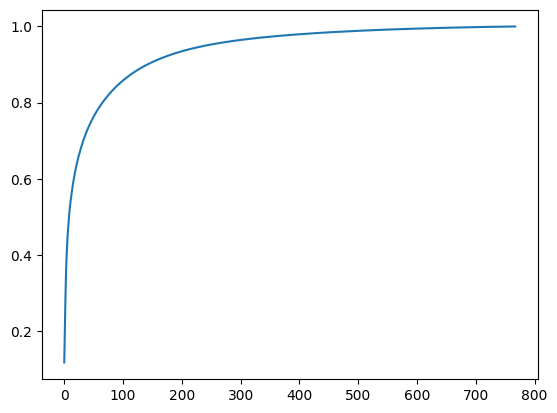

In [38]:
pca = PCA().fit(x_train)
var = pca.explained_variance_ratio_
for i in range(1, len(var)):
    var[i] = var[i - 1] + var[i]
plt.plot(var)

The following code allows us to plot different components so we can see the high dimensional data in different low dimensional representations. Overall the data does not seem very separable as there is a low of overlap when plotting different principal components. However, the genre anime seems pretty seperable compared to the rest which is logical since those songs are in japanese so the embeddings should be vastly different.

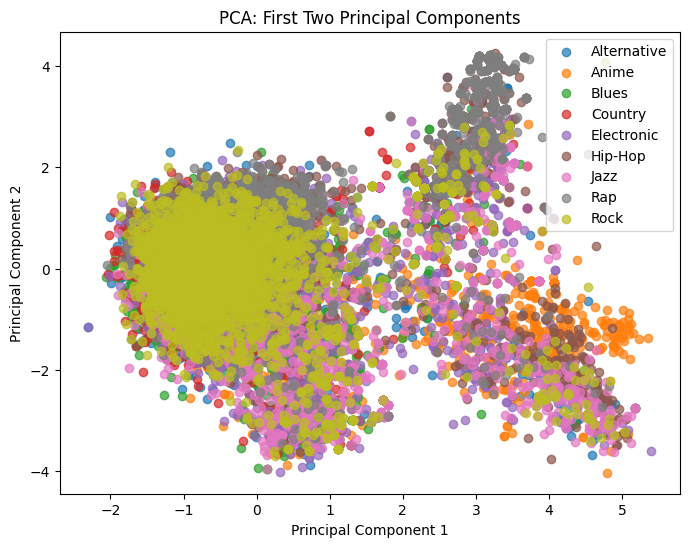

In [39]:
component1 = 1 # change as necessary
component2 = 2

X_pca = pca.transform(x_train)

plt.figure(figsize=(8, 6))

y_train_original = label_encoder.inverse_transform(y_train)

for i in np.unique(y_train_original):
    plt.scatter(X_pca[y_train_original == i, component1 - 1], X_pca[y_train_original == i, component2 - 1], label=i, alpha=0.7)

plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component ' + str(component1))
plt.ylabel('Principal Component ' + str(component2))
plt.legend()
plt.show()

## Methods

We will first attempt LDA to get a general idea of how the data is separated. Then we will do Logistic Regression since we can add a regularization penalty to the coefficients which may help with the high dimensional data. We will next try KNN which can give a more dynamic decision bounday. Lastly we will try Random Forest which can work well with the few strong predictors.

### LDA

From LDA we can see that the test error is around 60%. The test error is around 58.5% and it doesn't seem to over fit that badly. This tells us that the genres are pretty overlapped since LDA fits guassian distributions to each class with equal covariance. From the confusion matrix we can see that the genre anime (row/column 2) is more singled out which is logical since the lyrics in anime are in japanese and the Bert model should have much different embeddings that the lyrics that are in engligh.

In [50]:
LDA = LinearDiscriminantAnalysis().fit(x_train, y_train)

In [51]:
pred = LDA.predict(x_train)
(pred != y_train).sum() / len(pred)

0.5226295630422888

In [52]:
pred = LDA.predict(x_test)
(pred != y_test).sum() / len(pred)

0.5857433171799281

In [53]:
confusion_matrix(y_test, pred)

array([[326,   2,  48,  44,  35,  81,  36,  59, 166],
       [ 12, 153,  23,   6,  33,  24,  53,  10,   6],
       [ 50,   2, 219,  85,  41,  20,  83,  16,  87],
       [ 37,   0,  75, 551,  25,  18,  46,  33,  81],
       [ 77,   4,  38,  13, 149,  52,  75,  34,  55],
       [ 36,   5,   6,  14,  29, 392,  49, 387,  23],
       [ 38,   9,  88,  21,  85,  55, 185,  27,  45],
       [ 86,   2,  12,  19,  32, 348,  19, 399,  41],
       [231,   4,  77, 151,  45,  11,  51,  16, 276]], dtype=int64)

### Logistic Regression
From Logistic Regression after trying different regularization parameter values we see that regardless of the penalty it has a test error of around 60%. In addition we can see that the model seems to overfit a little and also from the confusion matrix we see that the genre Anime (column 2) seems to be more easily singled out than the other ones.

In [46]:
LR = LogisticRegression(max_iter=10000, penalty='l2', C=0.4).fit(x_train, y_train)

In [47]:
pred = LR.predict(x_train)
(pred != y_train).sum() / len(pred)

0.5185648401469554

In [48]:
pred = LR.predict(x_test)
(pred != y_test).sum() / len(pred)

0.5876191964983586

In [49]:
confusion_matrix(y_test, pred)

array([[329,   3,  33,  57,  28,  88,  32,  64, 163],
       [ 13, 171,  17,   9,  25,  22,  45,   9,   9],
       [ 50,  14, 205,  86,  42,  25,  65,  13, 103],
       [ 31,   2,  60, 564,  23,  24,  35,  33,  94],
       [ 92,  24,  27,  25, 128,  55,  67,  28,  51],
       [ 34,  10,   5,  21,  26, 429,  31, 368,  17],
       [ 42,  23,  81,  36,  83,  63, 150,  26,  49],
       [ 81,   3,   8,  30,  26, 374,  18, 377,  41],
       [228,  11,  59, 164,  42,  16,  38,  19, 285]], dtype=int64)

### KNN
We use cross validation to choose the number of neighbors to use. We can see that using 50 neighbors provides the highest cross validation accuracy. We then use 50 neighbors to get a test error of 65%. We also know that using very high k values does not provide much accuracy since the problem is unbalanced and will result in us not predicting a genre. Overall KNN does not provide very good performance since there is so much overlap between the genres. 

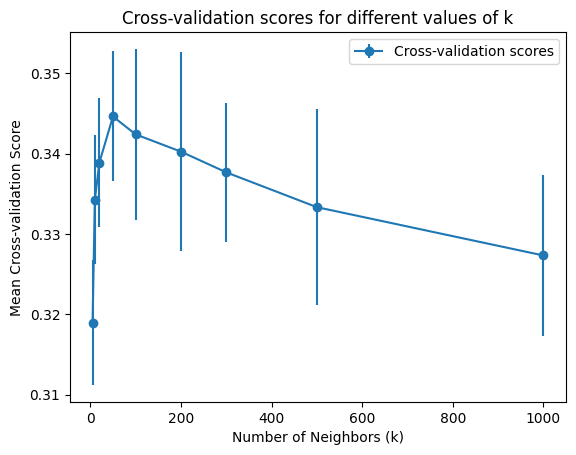

In [62]:
kf = KFold(n_splits=8, shuffle=True, random_state=12345)

k_values = [5, 10, 20, 50, 100, 200, 300, 500, 1000]

mean_scores = []
std_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cross_val_scores = cross_val_score(knn, x_train, y_train, cv=kf)
    
    mean_scores.append(np.mean(cross_val_scores))
    std_scores.append(np.std(cross_val_scores))

plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='o-', label='Cross-validation scores')
plt.title('Cross-validation scores for different values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-validation Score')
plt.legend()
plt.show()

In [58]:
KNN = KNeighborsClassifier(n_neighbors=50).fit(x_train_norm, y_train)

In [59]:
pred = KNN.predict(x_test_norm)
(pred != y_test).sum() / len(pred)

0.6554634985149289

### Random Forest Classifier
We use n_estimators of 50 since having more makes it too computationally expensive and does not solve the issues that we are having. Overall the RFC provides high test error since there is so much overlap between genres that using a decision tree to split the data does not result in very good node purity. The variable importance plot also tells us that there are a some strong predictors while the rest provide alot less information.

In [18]:
RFC = RandomForestClassifier(n_estimators=50).fit(x_train, y_train)

In [19]:
pred = RFC.predict(x_train)
(pred != y_train).sum() / len(pred)

0.1551238958805597

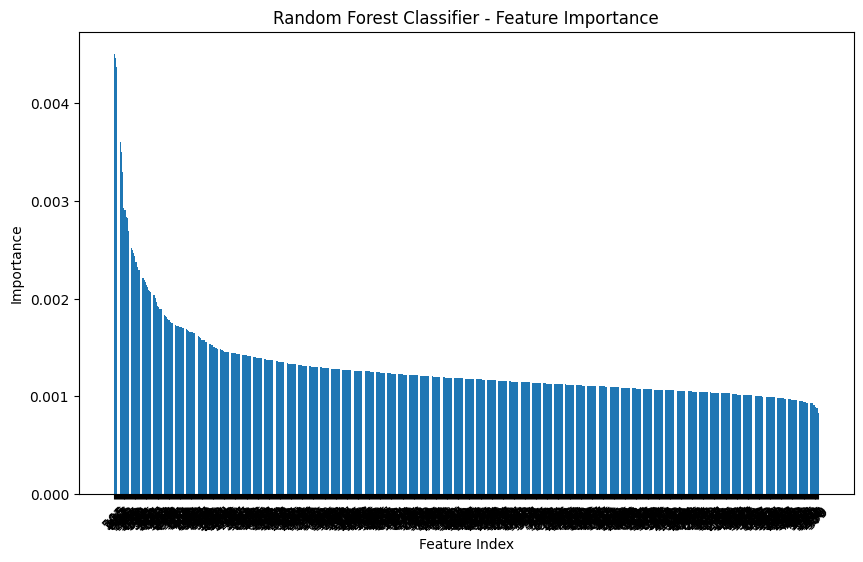

In [20]:
importances = RFC.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Classifier - Feature Importance')
plt.show()

### Support Vector Machine
SVM provides different kernels which might allow us to find a separable boundary. However, it is very computationally expensive.

To do...

## Conclusion
Embedding Song lyrics using bert-base-uncased does not provide separable boundaries that separate song genre. The exception to this is anime since the lyrics are in japanese. This makes sense since some songs in different genres may have the similar themes which means that the words used may be similar. For instance, Rap and Hip-Hop might have similar lyrics. In conclusion, embedding the lyrics does not provide a large increase in predictive power.